# Практика по PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
DTYPE = torch.float32

matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)
%matplotlib inline

torch.manual_seed(1)
torch.set_num_threads(12)
print('Threads:', torch.get_num_threads())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_default_device(DEVICE)

print(DEVICE)

Threads: 12
cpu


## Определения

In [3]:
def f(x, y):
    return torch.sin(x + 2 * y) * torch.exp(-torch.pow((2 * x + y), 2))

#def f(x, y):
#    return torch.sin(y) + torch.cos(x) # for debug and develop

def getRandVector(n):
    v = torch.rand(n, dtype=DTYPE)
    return v * 20.0 - 10.0

## Dataset

In [4]:
n = 20000 # Размер выборки

X = torch.stack((getRandVector(n), getRandVector(n)), dim=1)
y = f(X[:, 0], X[:, 1])
y.unsqueeze_(1)

print(X)
print(y)

tensor([[ 5.1526,  9.3444],
        [-4.4138, -5.4352],
        [-1.9386,  7.8446],
        ...,
        [-0.4212, -4.3007],
        [-4.4959,  4.1709],
        [ 1.1896, -7.2775]])
tensor([[-0.0000e+00],
        [-0.0000e+00],
        [ 1.3517e-07],
        ...,
        [-1.2732e-12],
        [-5.2232e-11],
        [-2.7254e-11]])


Text(0.5, 0, 'f(x, y)')

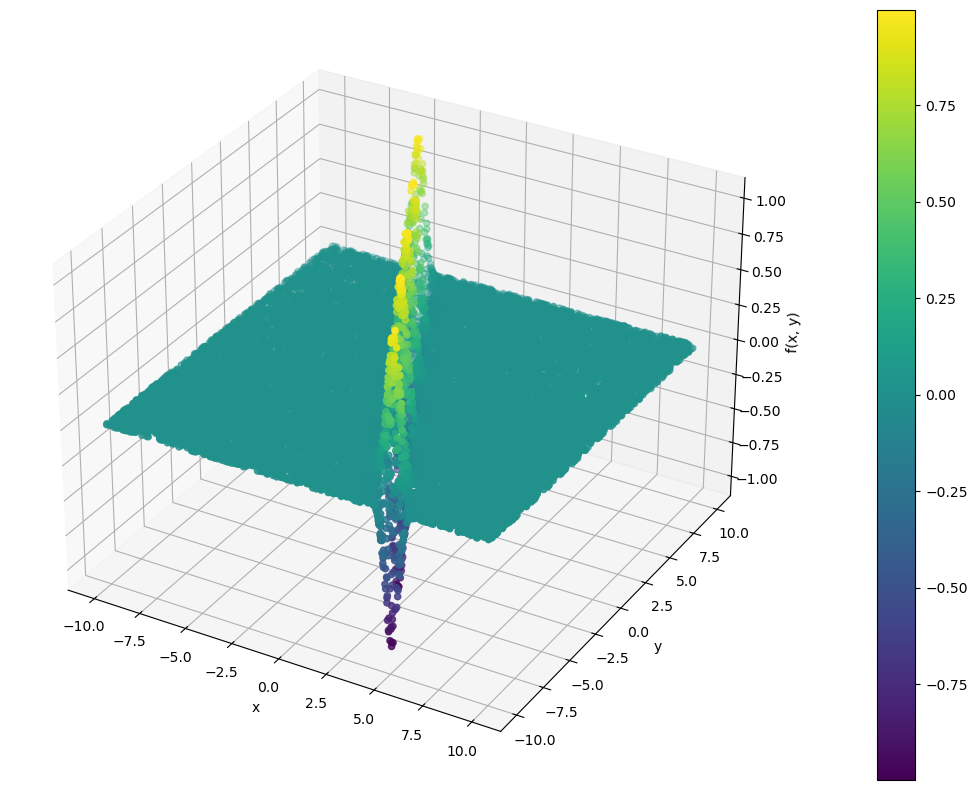

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dia = ax.scatter(X[:,0].cpu().numpy(), X[:,1].cpu().numpy(), y.cpu().detach().numpy(), c=y.cpu().detach().numpy(), cmap="viridis")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

## Split dataset to train/test/val
Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

y_train.device


device(type='cpu')

## Определяем модель

In [9]:
def init_model(n): # n — число нейронов в скрытом слое
    model = RegressionModel(n)
    criterion = loss_MSE
    optimizer = optim.AdamW(model.parameters(), lr=0.001) # lr=0.01

    return model, criterion, optimizer


class RegressionModel(nn.Module):
    def __init__(self, hidden_size, post_size = 200):
        super(RegressionModel, self).__init__()

        self.fc1 = nn.Linear(2, hidden_size, dtype=DTYPE)
        self.act1 = torch.nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, 1, dtype=DTYPE)


    def normalizeInput(self, x):
        # Normalization to range [-1; 1]
        return x / 10


    def forward(self, x):
        x = self.normalizeInput(x)
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        return x


    def getMetric(model, X_val, y_val):
        y_val_pred = model.forward(X_val)

        mse = loss_MSE(y_val_pred, y_val).detach().numpy()
        #mse = mean_squared_error(y_val_pred.detach().numpy(), y_val.detach().numpy())
        return mse


# если метрика не улучшилась больше чем на level% на протяжении последних 5ти эпох,
# то нейросеть уже дошла до своего предела, так считаем, и останавливаем обучение сети.
# verbose_only — параметр для отладки, когда выводится информация, а реальной остановки не делается
def isStop(mse_list, level=0.005, mseLevel=0.001, verbose_only=False):
    if len(mse_list) >= 5 and mse_list[-1] <= mseLevel:
        n = 4
        events = 0

        if verbose_only:
            print('——————————————')

        for i in range(-n - 1, -1):
                if abs(mse_list[-1] - mse_list[i]) / mse_list[i] < level:
                    if verbose_only:
                        print(mse_list[-1], mse_list[i], abs(mse_list[-1] - mse_list[i]) / mse_list[i])
                    else:
                        events = events + 1

        if events == n:
            return True

    return False


def loss_MSE(pred, target):
    squares = torch.pow(pred - target, 2)
    mse = squares.cpu().mean()
    return mse


def DoTrain(model, criterion, optimizer, num_epochs, stopLevel, mseLevel, X_train, y_train):
    mse_list = []
    for epoch_index in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        mse_list.append(model.getMetric(X_val, y_val))

        #if epoch_index % 300 == 0:
        #isStop(mse_list, level=stopLevel, verbose_only=True)

        if isStop(mse_list, level=stopLevel, mseLevel = mseLevel):
            break

    print('Обучение нейронной сети завершено.')
    print("MSE по валидац. выборке: {:.3f}".format(model.getMetric(X_val, y_val)))

    #print(mse_list)
    return mse_list


def DrawResultsOfTrain(model, mse_list):
    fig = plt.figure()
    ax = fig.add_subplot(122)
    ax.plot(mse_list, lw=3)
    ax.set_title("Training metric by validation dataset", size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    y_pred = model.forward(X_val)

    ax = fig.add_subplot(121, projection='3d')
    dia = ax.scatter(X_val[:, 0].cpu().numpy(), X_val[:, 1].cpu().numpy(), y_pred.cpu().detach().numpy(), c=y_pred.cpu().detach().numpy(), cmap="viridis")
    fig.colorbar(dia)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('y_pred')
    plt.show()

## Подбираем гиперпараметр (число нейронов) и тренируем модель

In [10]:
def RunHyperparamSearch(parameter, X_train, y_train, num_epochs, stopLevel, mseLevel):
    result_model = None
    result_mse_list = []
    best_mse = 1e8
    best_parameter = parameter[0]

    print('Подбор гиперпараметра:', parameter)

    for p in parameter:
        print('Значение параметра:', p)
        model, criterion, optimizer = init_model(p)
        mse_list = DoTrain(model, criterion, optimizer, num_epochs, stopLevel, mseLevel, X_train, y_train)
        if mse_list[-1] < best_mse:
            best_mse = mse_list[-1]
            result_model = model
            best_parameter = p
            result_mse_list = mse_list
    
    print('Лучшее значение параметра: ', best_parameter)
    
    return result_model, result_mse_list

In [11]:
parameter = [64, 96, 128]
num_epochs = 1000000 # Число эпох
stopLevel = 0.003 # Критерий остановки обучения
mseLevel = 0.005 # Требуемый уровень ошибки MSE

model, mse_list = RunHyperparamSearch(parameter, X_train, y_train, num_epochs, stopLevel, mseLevel)

DrawResultsOfTrain(model, mse_list)

Подбор гиперпараметра: [64, 96, 128]
Значение параметра: 64


  2%|▋                                              | 15595/1000000 [01:15<1:19:22, 206.70it/s]


KeyboardInterrupt: 

## Проверяем результат

RegressionModel(
  (fc1): Linear(in_features=2, out_features=25, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=25, out_features=1, bias=True)
)
MSE по тестовой выборке: 0.002


Text(0.5, 0, 'y_pred')

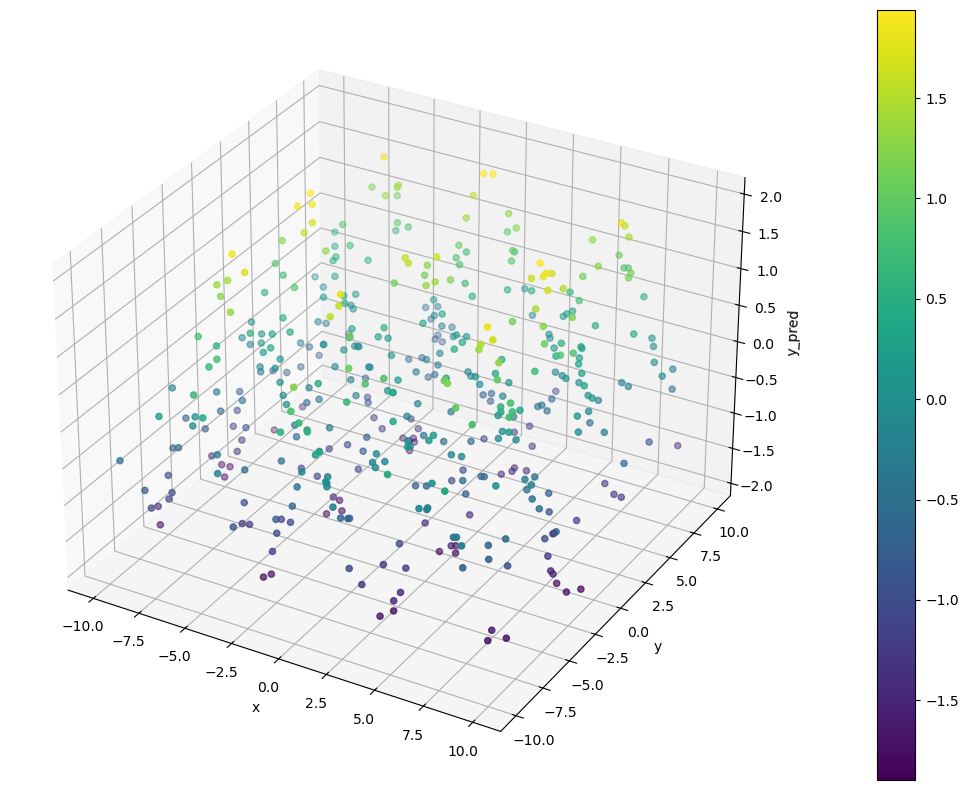

In [44]:

print(model.eval()) # Переводим модель в режим inference

print("MSE по тестовой выборке: {:.3f}".format(model.getMetric(X_test, y_test)))

y_pred = model.forward(X_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dia = ax.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), y_pred.cpu().detach().numpy(), c=y_pred.cpu().detach().numpy(), cmap="viridis")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('y_pred')


## График абсолютного значения ошибок

Text(0.5, 0, 'abs(y_pred - y_test)')

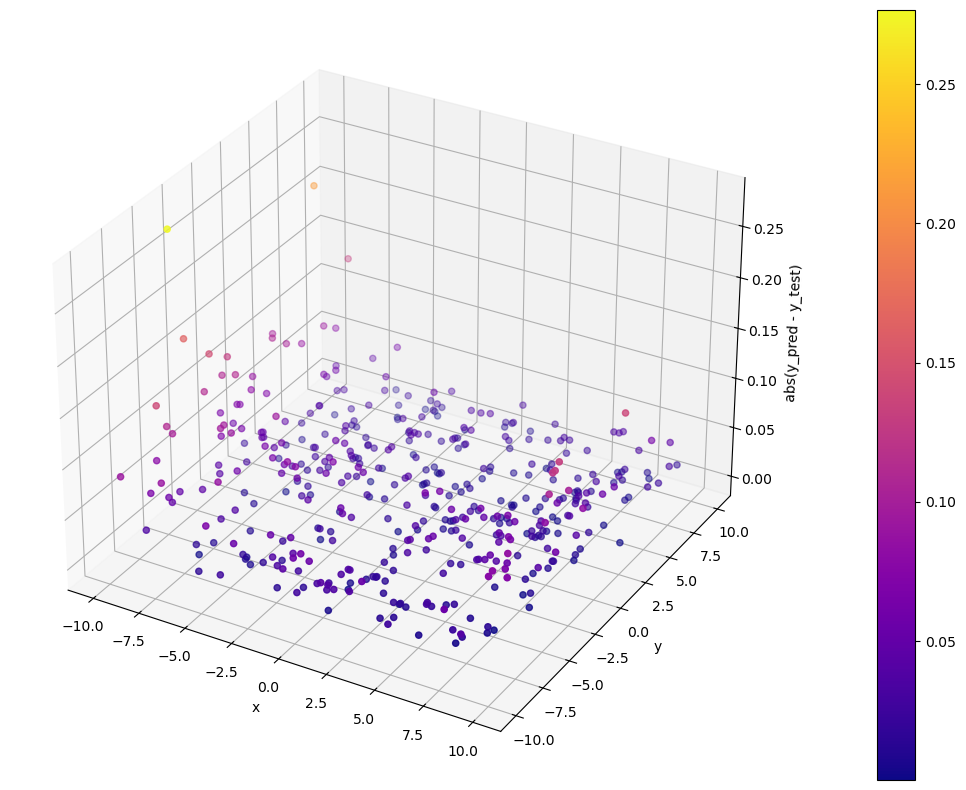

In [45]:
y_error = abs(y_pred - y_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dia = ax.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), y_error.cpu().detach().numpy(), c=y_error.cpu().detach().numpy(), cmap="plasma")
fig.colorbar(dia)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('abs(y_pred - y_test)')